In [13]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'     
blue4 = '#3182bd'     # passenger colour
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'   # dev colour
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'     # neutral drift colour
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [14]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

In [15]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import csv
from scipy.integrate import simps
import cmath
import mpmath as mp

In [16]:
Bolton_panel_size = 1139322  # bp

non_syn_mu_per_bp = 1.3617021276595745e-09
mu_per_bp = 1.9007092198581563e-09
Bolton_468panel_mu = mu_per_bp*Bolton_panel_size
Bolton_468panel_non_syn_mu = non_syn_mu_per_bp*Bolton_panel_size

print('Bolton_468panel_mu', Bolton_468panel_mu)
print('Bolton_468panel_non_syn_mu', Bolton_468panel_non_syn_mu)



Bolton_468panel_mu 0.0021655198297872344
Bolton_468panel_non_syn_mu 0.0015514171914893617


### Define DFE in healthy blood

In [17]:
# expo power + delta + p free
p_inferred = 2.62978687
q_inferred = 0.07713325
ratio_nonneutral = 0.02081683
s_max_inferred = float('inf')
Bolton_468panel_mu = 0.0021655198297872344

Bolton_468panel_functional_non_syn_mu = Bolton_468panel_mu*ratio_nonneutral
print('Bolton_468panel_functional_non_syn_mu', Bolton_468panel_functional_non_syn_mu)

Bolton_468panel_functional_non_syn_mu 4.50792581583098e-05


# Define the passenger prediction

In [7]:
import scipy.special as sc

N_tau=10**5

# # log concave
# weight_s= lambda s: np.exp(-((abs(s))/d_inferred)**b_inferred)
# normalization=integrate.quad(weight_s, 0.0, s_max_inferred)[0]

# # log convex
weight_s= lambda s: np.exp(-((abs(s))/q_inferred)**p_inferred)
normalization=integrate.quad(weight_s, 0.0, float("inf"))[0]

#  dummy factor for efficiency of evaluation
def hitchhikers_major_contribution_with_cutoff(l, N_tau, t, u_driver, s):
    
    N = N_tau
    f=np.exp(l)

    lower_limit = (2*N*f/(1-2*f))*s*(N*s-1+np.exp(s*t))*np.exp(-s*t) # is larger than upper_limit
    upper_limit = (2*N*f/(1-2*f))*N*s**2*np.exp(-s*t)

    problematic_large_term_log = np.log((2*N*f/(1-2*f))*N*s**2)+(N*s-1)*(2*N*f/(1-2*f))*s*np.exp(-s*t)-s*t
#         print('problematic_large_term_log',problematic_large_term_log)

    dummy_factor_log = np.log(10**-1)
    approximate_integral = lambda x: mp.exp(dummy_factor_log+problematic_large_term_log-x)/x
    ok_term = float(mp.quad(approximate_integral, [lower_limit, upper_limit]))/np.exp(dummy_factor_log)

    expected_density = 2*(1/(1-2*f))*N**2*u_driver*((np.exp(-(2*N*f/(1-2*f))*s*np.exp(-s*t))-np.exp(-(2*N*f/(1-2*f))*s))\
                                        +ok_term)

    
    return expected_density


def expected_density_hitchhiker_mutants_s_single(t, l, s1, b, d, mu_ben, N_tau): #s1 = fitness of 1st mutation, s2 = fitness of 2nd mutation

    u_driver_at_s1 = mu_ben*np.exp(-((abs(s1))/d)**b)/normalization

    expected_density_major_contribution = hitchhikers_major_contribution_with_cutoff(l, N_tau, t, u_driver_at_s1, s1)
    
    expected_density_minor_contribution = 2*np.exp(l)*N_tau*u_driver_at_s1/(np.exp(l)*s1*(1-2*np.exp(l)))*(-s1*t*np.exp(-(2*N_tau*np.exp(l)/(1-2*np.exp(l)))*s1)+sc.expi(-(2*N_tau*np.exp(l)/(1-2*np.exp(l)))*s1) -\
                                                   sc.expi(-(2*N_tau*np.exp(l)/(1-2*np.exp(l)))*s1*np.exp(-s1*t)))
    
    expected_density = (expected_density_major_contribution + expected_density_minor_contribution)
    
    return expected_density



def expected_number_hitchhiker_mutants(t, l, b, d, mu_ben, s_lower, s_upper, N_tau):
    
    result = integrate.quad(lambda s_var: expected_density_hitchhiker_mutants_s_single(t,  l, s_var,\
                                                                        b, d, mu_ben, N_tau), s_lower, s_upper)[0]

    return result

def logProbtheory_actual_ages_hitch(l, params, N_tau, s_lower, s_upper, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    b = params[0] 
    d = params[1]
    mu_ben= params[2]
    
    age_bins_positions=np.linspace(0,100,21)
    hist, bins =np.histogram(list_of_control_ages, bins=age_bins_positions)
    bin_centres = (bins[:-1] + bins[1:])/2

    for i in range(len(bin_centres)):
        age = bin_centres[i]
        number_of_people = hist[i]
        if number_of_people!=0:
            total_density= total_density + expected_number_hitchhiker_mutants(age, l, b, d, mu_ben, s_lower, s_upper, N_tau)*number_of_people/len(list_of_control_ages)
    
    
    return np.log(total_density)



# Plot the passenger prediction 

In [8]:
s_tolerance=3.5/100
print('The DFE has a lower cutt off at s=', s_tolerance)

list_of_control_ages = [20]

color_6p = '#1a9641'
color_9p = '#a6d96a'
color_12p = '#fdae61' # orange
color_15p = '#d7191c' # red
color_beyond15p = '#756bb1' # purple

The DFE has a lower cutt off at s= 0.035


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: divide by zero encountered in log


Time:  201.67431570000008


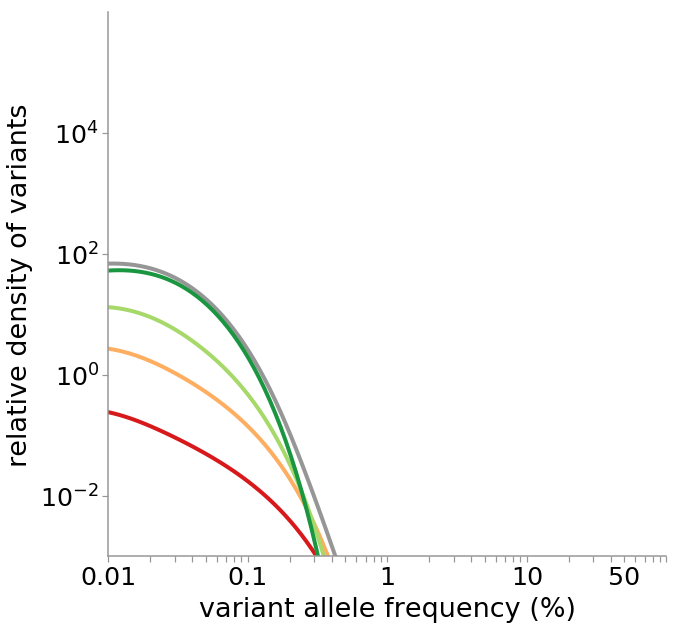

In [21]:
# # if log convex
import timeit

start = timeit.default_timer()

s_max_inferred = 1 # same result as 10

plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 25}

x_passenger=np.linspace(np.log(10**-4), np.log(0.4999999), 100)


y_passenger_total = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, s_tolerance, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_total, c = grey3, lw = 4, label= 'total from 3.5 %')

y_passenger_beyond_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.2, 0.25, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_15p, c = color_beyond15p, lw = 4, label= 'beyond 20 %')

y_passenger_beyond_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.15, 0.2, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_12p, c = color_15p, lw = 4, label= '15 - 20 %')

y_passenger_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.12, 0.15, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_12p, c = color_12p, lw = 4, label= '12 - 15 %')

y_passenger_9p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.09, 0.12, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_9p, c = color_9p, lw = 4, label= '9 - 12 %')

y_passenger_6p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.035, 0.09, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_6p, c = color_6p, lw = 4, label= '3.5 - 9 %')

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4),np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont*1.5)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [\
#                  np.log(10**-14), np.log(10**-12), np.log(10**-10), np.log(10**-8), np.log(10**-6),\
#                  np.log(10**-4), \
                 np.log(10**-2),\
                 np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = [\
#                        "$10^{-14}$","$10^{-12}$","$10^{-10}$","$10^{-8}$","$10^{-6}$",\
#                        "$10^{-4}$",\
                       "$10^{-2}$",\
                      "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont*1.5)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# ax1.legend(frameon=0, fontsize= 18)

# ax1.set_title('Age 80', fontsize=20)

# plt.savefig('pfree_mpfinalized_age20_all468_genes.pdf', bbox_inches='tight')        

stop = timeit.default_timer()

print('Time: ', stop - start)

### Import Bolton ages

In [26]:
filename='Ahmet_silent_calls.csv'


untreated_patients={}
with open(filename) as data:
    
    reader = csv.DictReader(data,delimiter=',')
    row_count = 0

    for row in reader:

        patient_id=str(row['DMP_PATIENT_ID'])
        gene=str(row['Gene'])
        variant_class=str(row['VariantClass'])
        vaf=float(row['N_AltFreq'])
        therapy_status=str(row['therapy_binary'])
        age=str(row['age'])
        
        if therapy_status=='untreated':
            
            #ages of all untreated patients are available
            if age=='NA':
                print('age unavailable')
                age=0
            
            untreated_patients[patient_id] =  float(age)
                
        row_count = row_count + 1
        
list_of_control_ages_Bolton=list(untreated_patients.values())
print('There are', len(list_of_control_ages_Bolton), 'untreated controls in Zehir')


There are 590 untreated controls in Zehir


y_passenger_total finished [5.026425821270863, 5.290132223783863, 5.5525858058318915, 5.813405592630831, 6.072096269464211, 6.328014941605937, 6.5803290037549145, 6.8279633098150665, 7.069534914857317, 7.303274196423436, 7.526932566151521, 7.737679947971801, 7.932000828374725, 8.105607597509632, 8.253406136550774, 8.369572785123722, 8.44783227143096, 8.482050625827535, 8.467238753252886, 8.40092739142991, 8.28454554122013, 8.124003625867195, 7.928657491838826, 7.708800289281223, 7.473141589697315, 7.227611606382589, 6.975449373802005, 6.717920543071002, 6.455230411280281, 6.18727563571136, 5.914032818531059, 5.635672855769196, 5.352540173172892, 5.065054097085349, 4.77357487090668, 4.478294902627206, 4.179199868881374, 3.8760935941523598, 3.5686409417074443, 3.256384661230334, 2.938717342144857, 2.6148041529117747, 2.2834417204408606, 1.9428033028205225, 1.5899427346941548, 1.2197171911683462, 0.8220604691104889, 0.37323939689077446, -0.207731559279932, -16.29544772849324]
y_passenger_

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: divide by zero encountered in log


y_passenger_15p finished [3.6761318737063298, 3.9389845069902876, 4.200323261064358, 4.459687803410917, 4.716479682658855, 4.969922225221667, 5.219009769307092, 5.462444149927943, 5.698556567827566, 5.925213888174287, 6.13971068812172, 6.338653188307293, 6.5178505805472655, 6.672246426400814, 6.795952204679526, 6.882490590107734, 6.925412670774725, 6.919482210282749, 6.86249670071503, 6.757301450482223, 6.6125771094756205, 6.440569788571507, 6.252213865883433, 6.053740918091925, 5.847451982807185, 5.634119865421451, 5.414258537586089, 5.18839248685988, 4.957072273252733, 4.720863734878484, 4.480334600008816, 4.236039544606864, 3.9885038527635697, 3.7382057345322983, 3.485557183928417, 3.230882987745909, 2.9743970840587335, 2.7161748306410085, 2.4561186705924074, 2.193912712944154, 1.9289578256299345, 1.66027068004589, 1.3863127142952332, 1.1046744088735758, 0.8114332783207584, 0.4996763545512168, 0.15547182036926432, -0.25629873483981397, -0.871612392951185, -inf]
y_passenger_12p finis

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in log


y_passenger_6p finished [2.075722973937869, 2.3414744669531404, 2.606596770832856, 2.8708973127027595, 3.1341248397283197, 3.395951723630753, 3.6559510616311024, 3.91356713991297, 4.168077502790925, 4.418544532121464, 4.66375414425148, 4.9021390722635845, 5.1316844492185965, 5.349814472163213, 5.553261587767812, 5.737925270324183, 5.898738385359659, 6.029579008236764, 6.123299346339258, 6.1719950975256515, 6.167701653121506, 6.103732811829038, 5.976732683515471, 5.788930834477612, 5.549003664357819, 5.269468170948202, 4.960953082640214, 4.627749338661996, 4.26807399222435, 3.8769283107705443, 3.448165605087527, 2.9752736955269854, 2.4516486687759738, 1.8706599963733088, 1.2254158666480637, 0.508090969950053, -0.29123249032522625, -1.1861699769804157, -2.196037032272328, -3.3483280210866053, -4.6822817978067075, -6.25555610300829, -8.158738462799693, -10.54765651366285, -13.717194576107378, -18.286561413793475, -25.836035102938062, nan, -74.5008287213688, -inf]


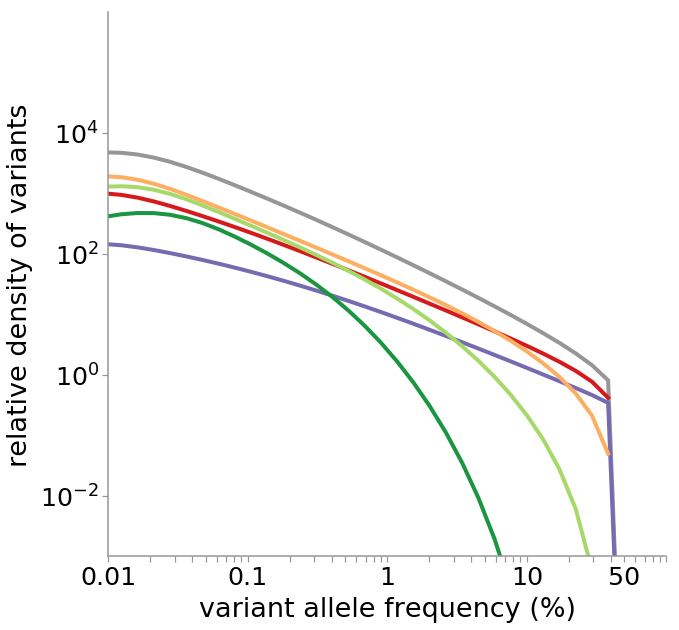

In [25]:
s_max_inferred = 1 # same result as 10

plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999999), 50)

y_passenger_total = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, s_tolerance, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_total, c = grey3, lw = 4, label= 'total from 3.5 %')
print('y_passenger_total finished', y_passenger_total)

y_passenger_beyond_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.15, s_max_inferred, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_beyond_15p, c = color_beyond15p, lw = 4, label= 'beyond 15 %')
print('y_passenger_beyond_15p finished', y_passenger_beyond_15p)

y_passenger_15p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.12, 0.15, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_15p, c = color_15p, lw = 4, label= '12 - 15 %')
print('y_passenger_15p finished', y_passenger_15p)

y_passenger_12p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.09, 0.12, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_12p, c = color_12p, lw = 4, label= '9 - 12 %')
print('y_passenger_12p finished', y_passenger_12p)

y_passenger_9p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.06, 0.09, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_9p, c = color_9p, lw = 4, label= '6 - 9 %')
print('y_passenger_9p finished', y_passenger_9p)

y_passenger_6p = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_functional_non_syn_mu], N_tau, 0.035, 0.06, list_of_control_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_6p, c = color_6p, lw = 4, label= '3.5 - 6 %')
print('y_passenger_6p finished', y_passenger_6p)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4),np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont*1.5, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont*1.5)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = [ "$10^{-2}$","$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont*1.5)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# ax1.legend(frameon=0, fontsize= 18)


# plt.savefig('pfree_mpfinalized_Bolton_ages_all468_genes.pdf', bbox_inches='tight')        


### Stored results

In [11]:
y_passenger_total = [5.026425821270863, 5.290132223783863, 5.5525858058318915, 5.813405592630831, 6.072096269464211, 6.328014941605937, 6.5803290037549145, 6.8279633098150665, 7.069534914857317, 7.303274196423436, 7.526932566151521, 7.737679947971801, 7.932000828374725, 8.105607597509632, 8.253406136550774, 8.369572785123722, 8.44783227143096, 8.482050625827535, 8.467238753252886, 8.40092739142991, 8.28454554122013, 8.124003625867195, 7.928657491838826, 7.708800289281223, 7.473141589697315, 7.227611606382589, 6.975449373802005, 6.717920543071002, 6.455230411280281, 6.18727563571136, 5.914032818531059, 5.635672855769196, 5.352540173172892, 5.065054097085349, 4.77357487090668, 4.478294902627206, 4.179199868881374, 3.8760935941523598, 3.5686409417074443, 3.256384661230334, 2.938717342144857, 2.6148041529117747, 2.2834417204408606, 1.9428033028205225, 1.5899427346941548, 1.2197171911683462, 0.8220604691104889, 0.37323939689077446, -0.207731559279932, -16.29544772849324]

y_passenger_beyond_15p = [1.8245146929442977, 2.086734041914294, 2.347249039154812, 2.6055436970676142, 2.8609488292543985, 3.1125987417463246, 3.359377286475337, 3.599851909541314, 3.83219526072193, 4.054096104437936, 4.26266570292519, 4.45435420018093, 4.624906337477264, 4.769410185167094, 4.88252810959081, 4.959038563875636, 4.994824404102759, 4.988319284335163, 4.942007552840052, 4.8628774170291, 4.760551129473671, 4.643548562287688, 4.516681977689125, 4.381570791685894, 4.238510117912693, 4.08754411082358, 3.9287251493549147, 3.762142877578897, 3.5879277796299185, 3.4062533293237323, 3.2173373140956163, 3.021441974141709, 2.8188727024345455, 2.6099751804220626, 2.395130942103862, 2.1747514541579474, 1.9492708626672595, 1.7191375730615277, 1.4848047721449347, 1.2467198067381646, 1.0053118627047313, 0.760976350252895, 0.5140520241248723, 0.2647808641504412, 0.013223831634984832, -0.24094904902146405, -0.49908883389898107, -0.7660223761326151, -1.0656743979811065, -16.294712855038185]

y_passenger_15p = [3.6761318737063298, 3.9389845069902876, 4.200323261064358, 4.459687803410917, 4.716479682658855, 4.969922225221667, 5.219009769307092, 5.462444149927943, 5.698556567827566, 5.925213888174287, 6.13971068812172, 6.338653188307293, 6.5178505805472655, 6.672246426400814, 6.795952204679526, 6.882490590107734, 6.925412670774725, 6.919482210282749, 6.86249670071503, 6.757301450482223, 6.6125771094756205, 6.440569788571507, 6.252213865883433, 6.053740918091925, 5.847451982807185, 5.634119865421451, 5.414258537586089, 5.18839248685988, 4.957072273252733, 4.720863734878484, 4.480334600008816, 4.236039544606864, 3.9885038527635697, 3.7382057345322983, 3.485557183928417, 3.230882987745909, 2.9743970840587335, 2.7161748306410085, 2.4561186705924074, 2.193912712944154, 1.9289578256299345, 1.66027068004589, 1.3863127142952332, 1.1046744088735758, 0.8114332783207584, 0.4996763545512168, 0.15547182036926432, -0.25629873483981397, -0.871612392951185, float('-inf')]

y_passenger_12p = [4.1751224246517555, 4.438747417788293, 4.7010931405908565, 4.961769478469338, 5.220268461619175, 5.475929458533004, 5.727894671683433, 5.975052670196947, 6.2159675164362325, 6.448791191575409, 6.671157883191507, 6.880060978215455, 7.07171859752749, 7.241443478461146, 7.383551731516427, 7.491378106401415, 7.557519117547737, 7.574498560697081, 7.536106344370084, 7.4395624415269435, 7.288091667747714, 7.092241250996769, 6.867437693832336, 6.627861145178352, 6.381783921544093, 6.132293416946677, 5.880335649288161, 5.626364068003137, 5.370686819162323, 5.113478911583562, 4.854759444741357, 4.594365592017839, 4.3319247930603275, 4.066825828248466, 3.798189694327259, 3.5248410928040284, 3.2452804503783304, 2.9576540484464005, 2.6597151043041367, 2.3487598756127515, 2.021506321324023, 1.6738508702294035, 1.3003786534296244, 0.8933805104858071, 0.44082701159021415, -0.07818941463975716, -0.705569562812138, -1.5461390593919648, -3.002758994467714, float('-inf')]

y_passenger_9p = [3.5167898895204117, 3.781442952427333, 4.045130730750043, 4.3075583070182795, 4.568341271012751, 4.8269790008735525, 5.082820283495462, 5.335019311591252, 5.582479773330757, 5.823784535144083, 6.057108493046356, 6.280112885840883, 6.489821382426945, 6.6824827686388755, 6.853434170250893, 6.99699599768468, 7.1064606138629705, 7.174287660040398, 7.192691622258459, 7.154875456011924, 7.0571141176021275, 6.9014378040104685, 6.697491927735528, 6.46095930495106, 6.207603464065842, 5.9473046630751565, 5.68341213945327, 5.415836400357329, 5.143356560452469, 4.864284510492708, 4.576542717940922, 4.277675444647918, 3.964878470255125, 3.635051542143803, 3.2848651285298747, 2.9108208200148247, 2.509269337516119, 2.0763364641587603, 1.6077012060422067, 1.098164392928049, 0.540904402390491, -0.07380056403181491, -0.7608087906178851, -1.5441323243622642, -2.4647355067048595, -3.598261704221217, -5.105526188906486, -7.42895812463368, -12.661779739305826, float('-inf')]

y_passenger_6p = [2.075722973937869, 2.3414744669531404, 2.606596770832856, 2.8708973127027595, 3.1341248397283197, 3.395951723630753, 3.6559510616311024, 3.91356713991297, 4.168077502790925, 4.418544532121464, 4.66375414425148, 4.9021390722635845, 5.1316844492185965, 5.349814472163213, 5.553261587767812, 5.737925270324183, 5.898738385359659, 6.029579008236764, 6.123299346339258, 6.1719950975256515, 6.167701653121506, 6.103732811829038, 5.976732683515471, 5.788930834477612, 5.549003664357819, 5.269468170948202, 4.960953082640214, 4.627749338661996, 4.26807399222435, 3.8769283107705443, 3.448165605087527, 2.9752736955269854, 2.4516486687759738, 1.8706599963733088, 1.2254158666480637, 0.508090969950053, -0.29123249032522625, -1.1861699769804157, -2.196037032272328, -3.3483280210866053, -4.6822817978067075, -6.25555610300829, -8.158738462799693, -10.54765651366285, -13.717194576107378, -18.286561413793475, -25.836035102938062, float('nan'), -74.5008287213688, float('-inf')]

### Contribution by age groups

In [20]:
np.percentile(list_of_control_ages, [25, 50, 75])

list_q1_ages = []
list_q2_ages = []
list_q3_ages = []
list_q4_ages = []
for age in list_of_control_ages:
    if age<= 61.5:
        list_q1_ages.append(age)
    if 61.5< age<= 67.5:
        list_q2_ages.append(age)
    if 67.5< age<= 74.9:
        list_q3_ages.append(age)
    if 74.9< age:
        list_q4_ages.append(age)

In [29]:
# fitness > 15 %
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999), 50)


y_passenger_q1 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.15, s_max_inferred, list_q1_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q1, c = color_beyond15p, alpha = 0.25, lw = 4, label= 'quartile 1')
print('y_passenger_q1', y_passenger_q1)

y_passenger_q2 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.15, s_max_inferred, list_q2_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q2, c = color_beyond15p, alpha = 0.5, lw = 4, label= 'quartile 2')
print('y_passenger_q2', y_passenger_q2)

y_passenger_q3 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.15, s_max_inferred, list_q3_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q3, c = color_beyond15p, alpha = 0.75, lw = 4, label= 'quartile 3')
print('y_passenger_q3', y_passenger_q3)

y_passenger_q4 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.15, s_max_inferred, list_q4_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q4, c = color_beyond15p, alpha = 1, lw = 4, label= 'quartile 4')
print('y_passenger_q4', y_passenger_q4)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4), np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = ["$10^{-2}$", "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.legend(frameon=0, fontsize= 18)


In [28]:
# fitness 12%< s< 15 %
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999), 50)


y_passenger_q1 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.12, 0.15, list_q1_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q1, c = color_15p, alpha = 0.25, lw = 4, label= 'quartile 1')
print('y_passenger_q1', y_passenger_q1)

y_passenger_q2 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.12, 0.15, list_q2_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q2, c = color_15p, alpha = 0.5, lw = 4, label= 'quartile 2')
print('y_passenger_q2', y_passenger_q2)

y_passenger_q3 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.12, 0.15, list_q3_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q3, c = color_15p, alpha = 0.75, lw = 4, label= 'quartile 3')
print('y_passenger_q3', y_passenger_q3)

y_passenger_q4 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.12, 0.15, list_q4_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q4, c = color_15p, alpha = 1, lw = 4, label= 'quartile 4')
print('y_passenger_q4', y_passenger_q4)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4), np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = ["$10^{-2}$", "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.legend(frameon=0, fontsize= 18)


In [27]:
# fitness 9%< s< 12 %
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999), 50)


y_passenger_q1 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.09, 0.12, list_q1_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q1, c = color_12p, alpha = 0.25, lw = 4, label= 'quartile 1')
print('y_passenger_q1', y_passenger_q1)

y_passenger_q2 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.09, 0.12, list_q2_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q2, c = color_12p, alpha = 0.5, lw = 4, label= 'quartile 2')
print('y_passenger_q2', y_passenger_q2)

y_passenger_q3 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.09, 0.12, list_q3_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q3, c = color_12p, alpha = 0.75, lw = 4, label= 'quartile 3')
print('y_passenger_q3', y_passenger_q3)

y_passenger_q4 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.09, 0.12, list_q4_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q4, c = color_12p, alpha = 1, lw = 4, label= 'quartile 4')
print('y_passenger_q4', y_passenger_q4)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4), np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = ["$10^{-2}$", "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.legend(frameon=0, fontsize= 18)


In [27]:
# fitness 6%< s< 9 %
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999), 50)


y_passenger_q1 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.06, 0.09, list_q1_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q1, c = color_9p, alpha = 0.25, lw = 4, label= 'quartile 1')
print('y_passenger_q1', y_passenger_q1)

y_passenger_q2 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.06, 0.09, list_q2_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q2, c = color_9p, alpha = 0.5, lw = 4, label= 'quartile 2')
print('y_passenger_q2', y_passenger_q2)

y_passenger_q3 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.06, 0.09, list_q3_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q3, c = color_9p, alpha = 0.75, lw = 4, label= 'quartile 3')
print('y_passenger_q3', y_passenger_q3)

y_passenger_q4 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.06, 0.09, list_q4_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q4, c = color_9p, alpha = 1, lw = 4, label= 'quartile 4')
print('y_passenger_q4', y_passenger_q4)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4), np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = ["$10^{-2}$", "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.legend(frameon=0, fontsize= 18)


In [27]:
# fitness 3.5%< s< 6%
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

x_passenger=np.linspace(np.log(10**-6), np.log(0.4999), 50)


y_passenger_q1 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.035, 0.06, list_q1_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q1, c = color_6p, alpha = 0.25, lw = 4, label= 'quartile 1')
print('y_passenger_q1', y_passenger_q1)

y_passenger_q2 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.035, 0.06, list_q2_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q2, c = color_6p, alpha = 0.5, lw = 4, label= 'quartile 2')
print('y_passenger_q2', y_passenger_q2)

y_passenger_q3 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.035, 0.06, list_q3_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q3, c = color_6p, alpha = 0.75, lw = 4, label= 'quartile 3')
print('y_passenger_q3', y_passenger_q3)

y_passenger_q4 = [logProbtheory_actual_ages_hitch(l, [p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral], N_tau, 0.035, 0.06, list_q4_ages) for l in x_passenger]
ax1.plot(x_passenger, y_passenger_q4, c = color_6p, alpha = 1, lw = 4, label= 'quartile 4')
print('y_passenger_q4', y_passenger_q4)

# Set axis limits
ax1.set_ylim(np.log(10**-3), np.log(1000000))
ax1.set_xlim(np.log(10**-4), np.log(0.5))

# # Axis labels
axisfont=14*1.2
axislabelfont=15*1.2

ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                 np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                 np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                 np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
x_major_tick_labels = ["0.01","","","","","","","","",\
                       "0.1","","","","","","","","",\
                       "1","","","","","","","","",\
                       "10","","","","50","","","","",""]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(10**-2), np.log(1), np.log(10**2), np.log(10**4)]
y_major_tick_labels = ["$10^{-2}$", "$10^{0}$","$10^{2}$","$10^{4}$",]

ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.legend(frameon=0, fontsize= 18)


# Analytical approximations

Analytical approximations to the most dominant s.

In [206]:
freq=2/100
print('freq',freq)
n_tau = 2*N_tau*freq/(1-2*freq)
print('n_tau:',n_tau)
t = max(list_of_control_ages)
t = 40
print('t',t)

first_order_derivative_A_C_only= lambda s: (-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t))
    
first_order_derivative_A_C_D_only= lambda s: ((-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t)))*np.exp(s*t-n_tau*s*np.exp(-s*t))-\
s*np.exp(-n_tau*s)*(n_tau*(np.exp(s*t)-1)+t*np.exp(s*t)+n_tau*s*t*np.exp(s*t))

first_order_derivative_A_B_C_D_only= lambda s: ((-2-p_inferred*(s/q_inferred)**p_inferred)+s*(t+(s*t+1)*n_tau*np.exp(-s*t)))*np.exp(s*t-n_tau*s*np.exp(-s*t))-\
s*np.exp(-n_tau*s)*(n_tau*(np.exp(s*t)-1)+t*np.exp(s*t)+n_tau*s*t*np.exp(s*t))+np.exp(-n_tau*s)*(np.exp(s*t)+n_tau*s*(np.exp(s*t)-1))*(s-(-2-p_inferred*(s/q_inferred)**p_inferred))
    

freq 0.02
n_tau: 4166.666666666667
t 40


In [79]:
from scipy.optimize import fsolve

predominant_s_initial_guess = 0.3

predominant_s_solution_A_C_only = fsolve(first_order_derivative_A_C_only, predominant_s_initial_guess)

predominant_s_solution_A_C_D_only = fsolve(first_order_derivative_A_C_D_only, predominant_s_initial_guess)

predominant_s_solution_A_B_C_D_only = fsolve(first_order_derivative_A_B_C_D_only, predominant_s_initial_guess)

print('predominant_s_solution_A_C_only ', predominant_s_solution_A_C_only)
print('predominant_s_solution_A_C_D_only ', predominant_s_solution_A_C_D_only)
print('predominant_s_solution_A_B_C_D_only ', predominant_s_solution_A_B_C_D_only)

predominant_s_solution_A_C_only  [0.11205507]
predominant_s_solution_A_C_D_only  [0.11205507]
predominant_s_solution_A_B_C_D_only  [0.11205507]


C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


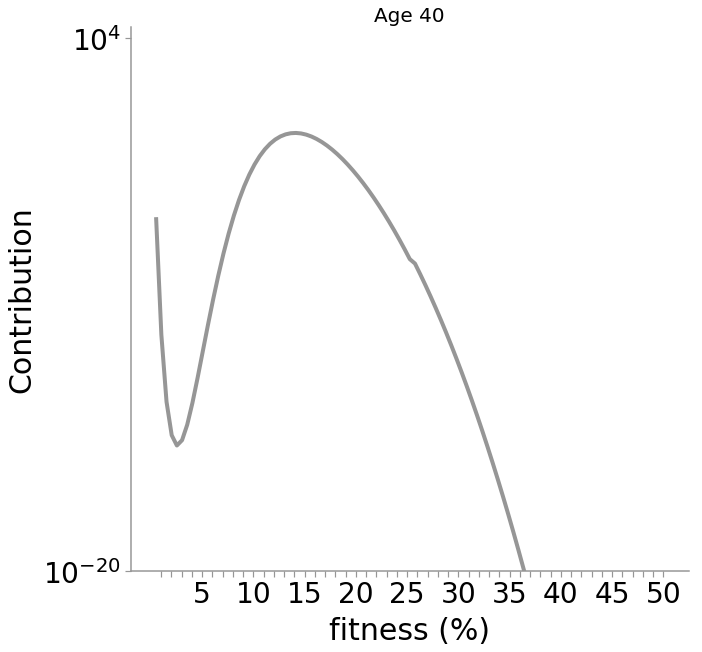

In [207]:
# Plot contribution to passenger spectrum from different s's
log_freq=np.log(freq)

plt.close('all')
scale = 1.2
fig, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(10, 10))
font = {'weight' : 'normal','size'   : 16}

# s_vector = np.linspace(0, s_max_inferred, 100)
s_vector = np.linspace(0, 0.5, 100)

Product = [np.log(expected_density_hitchhiker_mutants_s_single(t, log_freq, s1, p_inferred, q_inferred, Bolton_468panel_mu*ratio_nonneutral, N_tau)) for s1 in s_vector]
ax1.plot(s_vector, Product, c = grey3, lw = 4, label= 'total')



# Set axis limits
ax1.set_ylim(np.log(10**-20), np.log(3*10**4))
# ax1.set_xlim(-9, 0)

# # Axis labels
axisfont=14*2
axislabelfont=15*2

ax1.set_xlabel('fitness (%)', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')
ax1.set_ylabel('Contribution', fontsize = axislabelfont, labelpad = 6*1.2, fontweight = 'medium')

x_major_ticks = np.linspace(0.01,0.5,50)
x_major_tick_labels = ["", "","","","5","", "","","", "10","", "","","","15","", "","","", "20","", "","","", "25","", "","","", "30"\
                       ,"", "","","", "35","", "","","", "40","", "","","", "45","", "","","", "50"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks =[np.log(10**-20), np.log(10**4)]
y_major_tick_labels = ["$10^{-20}$", "$10^{4}$"]
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)
# ax1.axvline(predominant_s_solution_A_C_only[0], color='black', linewidth=4, linestyle='--', zorder = 0)



#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
ax1.set_title('Age 40', fontsize=20)
